In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("E-commerce cosmetic dataset.csv", encoding = "latin-1")
df.head(3)

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,type,color,size,rating,noofratings
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,Carlton London,NaN,aerosol,NaN,"Top Note: Orange Blossom, Blackberry | Heart N...",100,3.9,19
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,Charlene,NaN,aerosol,NaN,Unit count type:,30,4.4,"4,031"
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,Charlene,NaN,aerosol,NaN,Unit count type:,30,4.4,"4,072"


In [3]:
def sizeclean(point):
    if type(point)==str:
        point=point.split(" ")[0]
        point=float(point)
    return point

In [4]:
df['size']=df['size'].apply(sizeclean)

In [5]:
# Convert the 'size' column to numeric, forcing errors to NaN
df['size'] = pd.to_numeric(df['size'], errors='coerce')

In [6]:
# Fill 'No type' for records with blank type value
df['type'] = df['type'].fillna('No type')
# Group by 'category' & 'subcategory' and fill NaN values with the mean of the group
df['size_cv'] = df.groupby(['category','subcategory'])['size'].transform(lambda x: x.fillna(x.mean()))
df['price_cv'] = df.groupby(['category','subcategory'])['price'].transform(lambda x: x.fillna(x.mean()))
df.isna().sum()

product_name       0
website            0
country            0
category           0
subcategory        0
title-href         0
price            317
brand              0
ingredients     6015
form               0
type               0
color           1989
size            3166
rating          2067
noofratings      459
size_cv            0
price_cv           0
dtype: int64

In [7]:
df.shape

(12615, 17)

Text(0.5, 1.0, 'Size_cv by Category')

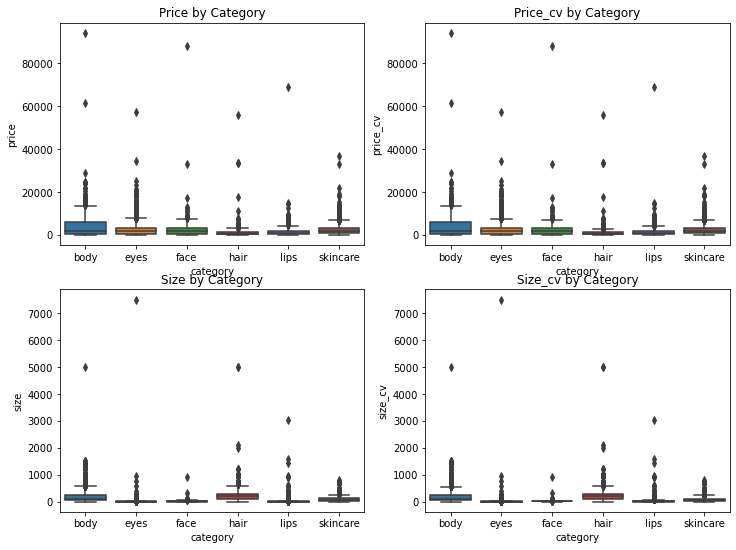

In [8]:
# check if the value after imputed with mean still have the same distribution
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))
sns.boxplot(ax=axes[0,0],x='category', y='price', data=df).set_title('Price by Category')
sns.boxplot(ax=axes[0,1],x='category', y='price_cv', data=df).set_title('Price_cv by Category')
sns.boxplot(ax=axes[1,0],x='category', y='size', data=df).set_title('Size by Category')
sns.boxplot(ax=axes[1,1],x='category', y='size_cv', data=df).set_title('Size_cv by Category')

**Option 1: Classify brand by price across all products**

In [9]:
# To remove the whitespaces front and back and convert to lower
df['brand'] = df['brand'].astype(str).str.strip().str.lower()

In [10]:
def classify_price(price):
    if price > 10000:
        return 'luxury brand'
    elif price < 2860:
        return 'budget'
    elif 2860 <= price <= 10000:
        return 'mid tier'
df['brand_group'] = df['price_cv'].apply(classify_price)

luxury_count = df[df['brand_group'] == 'luxury brand'].shape[0]
budget_count = df[df['brand_group'] == 'budget'].shape[0]
mid_tier_count = df[df['brand_group'] == 'mid tier'].shape[0]

print(luxury_count,mid_tier_count,budget_count,luxury_count+mid_tier_count+budget_count )
# print(df)

296 2792 9527 12615


**Option 2: Classify brand/product class by price percentile in each category**

In [11]:
# Function to classify based on percentiles
def classify_price(x):
    if x <= 0.6:
        return 'Regular'
    elif x <= 0.95:
        return 'Premium'
    else:
        return 'Super Premium'

In [12]:
# The groupby method is used to group the DataFrame by the brand column.
# The transform method along with rank(pct=True) calculates the percentile rank for each price within its brand group
df['percentile'] = df.groupby('category')['price_cv'].transform(lambda x: x.rank(pct=True))

df['product_class'] = df['percentile'].apply(classify_price)

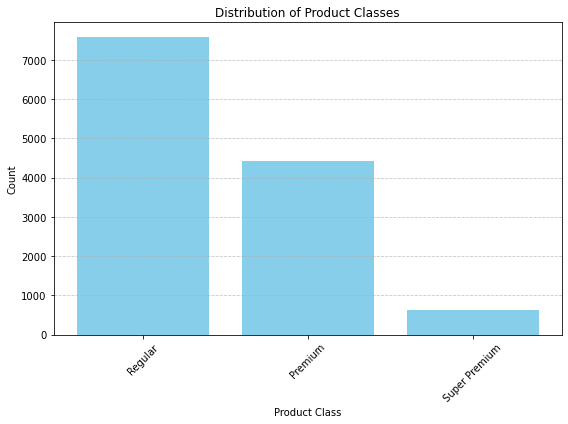

In [13]:
# Create a count plot (bar chart)
plt.figure(figsize=(8, 6))
plt.title('Distribution of Product Classes')
plt.xlabel('Product Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot the counts
plt.bar(df['product_class'].value_counts().index, df['product_class'].value_counts().values, color='skyblue')

# Show the plot
plt.tight_layout()
plt.show()

In [14]:
# Group by brand and product_class, and count occurrences
product_class_counts = df.groupby(['brand', 'product_class']).size().reset_index(name='count')

# Find the product class with the maximum count for each brand
max_product_class = product_class_counts.loc[product_class_counts.groupby('brand')['count'].idxmax()]

# Reset index for the final DataFrame
max_product_class = max_product_class.reset_index(drop=True)
max_product_class.rename(columns={'product_class':'brand_class'}, inplace=True)
print(max_product_class.shape, df.brand.nunique())
max_product_class.head(3)

(1646, 3) 1646


,brand,brand_class,count
0,100% pure,Premium,1
1,1000hour,Premium,1
2,18.21 man made,Regular,1


In [15]:
df = df.merge(max_product_class[['brand', 'brand_class']], on = 'brand', how = 'left')
df.head()

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,...,color,size,rating,noofratings,size_cv,price_cv,brand_group,percentile,product_class,brand_class
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,carlton london,NaN,aerosol,...,"Top Note: Orange Blossom, Blackberry | Heart N...",100.0,3.9,19,100.0,599.0,budget,0.257926,Regular,Regular
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,charlene,NaN,aerosol,...,Unit count type:,30.0,4.4,"4,031",30.0,149.0,budget,0.030528,Regular,Regular
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,charlene,NaN,aerosol,...,Unit count type:,30.0,4.4,"4,072",30.0,298.0,budget,0.120352,Regular,Regular
3,DENVER Black Code Perfume - 60 | Eau de Parfum...,Flipkart,India,body,perfume,https://www.amazon.in/DENVER-Black-Code-Perfum...,245.0,denver,NaN,aerosol,...,Long-Lasting Scent,60.0,4.2,61,60.0,245.0,budget,0.087084,Regular,Regular
4,Denver Hamilton Perfume - 100 | Long Lasting P...,Flipkart,India,body,perfume,https://www.amazon.in/Denver-Perfume-Hamilton-...,422.0,denver,NaN,aerosol,...,Long-Lasting Scent,100.0,4.3,342,100.0,422.0,budget,0.194912,Regular,Regular


**rating/noofratings Column Transform:**  if noofratings is blank & rating >10, then rating is noofratings. For the rest impute missing values using mean/median of the sub-category

In [16]:
df['rating'] = df['rating'].str.split(" ").str[0]
df['rating'] = df['rating'].str.replace(',', '')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
incorrect_ratings = df['rating'] > 10
df.loc[incorrect_ratings, 'noofratings'] = df.loc[incorrect_ratings, 'rating']
df.loc[incorrect_ratings, 'rating'] = 0

In [17]:
def ratingno(point):
    if point in ('Write A Review','No reviews','New to Amazon'):
        point = 0
    elif type(point)==str:
        point=point.split(" ")[0]
        point=point.replace(",","")
        point=float(point)
    return point
df['noofratings_cv']=df['noofratings'].apply(ratingno)

In [18]:
df['rating'] = df.groupby('subcategory')['rating'].transform(lambda x: x.fillna(x.mean()).mask((x == 0) | (x > 5), x.mean()))
df['rating'] = df['rating'].round(1)

In [19]:
print(df.shape)
df.isna().sum()

(12615, 22)


product_name         0
website              0
country              0
category             0
subcategory          0
title-href           0
price              317
brand                0
ingredients       6015
form                 0
type                 0
color             1989
size              3166
rating             674
noofratings        405
size_cv              0
price_cv             0
brand_group          0
percentile           0
product_class        0
brand_class          0
noofratings_cv     405
dtype: int64

In [20]:
global_df = pd.read_csv("brand_geo.csv")
global_df.head(10)

,brand,global/local
0,7 DAYS,local
1,about-face,global
2,ADAMAI,global
3,AG Care,global
4,All,NaN
5,Almay,global
6,ALVRIO,local
7,Amosfia,global
8,ANIQUï¿½,local
9,Avï¿½ï¿½,global


In [21]:
# To remove the whitespaces front and back and convert to lower
global_df['brand'] = global_df['brand'].astype(str).str.strip().str.lower()
global_df['global/local'] = global_df['global/local'].astype(str).str.strip()
df = df.merge(global_df[['brand', 'global/local']], on = 'brand', how = 'left')
df['global/local'].fillna("others", inplace=True)
df['global/local'].replace("nan", "others", inplace=True)
df.head(3)

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,...,rating,noofratings,size_cv,price_cv,brand_group,percentile,product_class,brand_class,noofratings_cv,global/local
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,carlton london,NaN,aerosol,...,3.9,19,100.0,599.0,budget,0.257926,Regular,Regular,19.0,others
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,charlene,NaN,aerosol,...,4.4,"4,031",30.0,149.0,budget,0.030528,Regular,Regular,4031.0,others
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,charlene,NaN,aerosol,...,4.4,"4,072",30.0,298.0,budget,0.120352,Regular,Regular,4072.0,others


In [22]:
global_df.head(10)

,brand,global/local
0,7 days,local
1,about-face,global
2,adamai,global
3,ag care,global
4,all,nan
5,almay,global
6,alvrio,local
7,amosfia,global
8,aniquï¿½,local
9,avï¿½ï¿½,global


# K-Means Clustering

In [27]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer

In [28]:
# Select features for clustering 
features = ['category', 'subcategory', 'ingredients', 'form', 'type', 'color', 'rating', 'price_cv', 'size_cv', 'noofratings_cv', 'product_class', 'brand_class', 'global/local']
X = df[features].dropna()

In [29]:
# One-hot encode categorical features
categorical_features = ['category', 'subcategory','ingredients', 'form', 'type', 'color', 'product_class', 'brand_class', 'global/local']
numeric_features = ['price_cv', 'size_cv', 'noofratings_cv', 'rating']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)

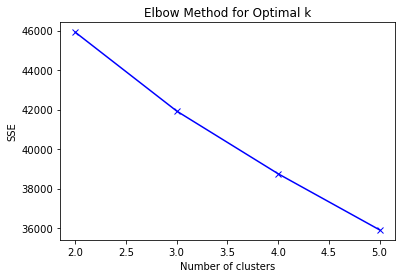

In [30]:
# Determine the optimal number of clusters using the Elbow method
sse = {}
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

In [31]:
# Print the SSE values for different k
print("SSE values for different numbers of clusters:")
for k in sse:
    print(f"Number of clusters: {k}, SSE: {sse[k]}")

# Find the elbow point (optimal k)
optimal_k = max(sse, key=lambda k: sse[k-1] - sse[k] if k-1 in sse else 0)
print(f"The optimal number of clusters based on the Elbow method is: {optimal_k}")

SSE values for different numbers of clusters:
Number of clusters: 2, SSE: 45919.38491536723
Number of clusters: 3, SSE: 41924.71542610519
Number of clusters: 4, SSE: 38746.50512608913
Number of clusters: 5, SSE: 35903.64191177376
The optimal number of clusters based on the Elbow method is: 3


In [33]:
df = df.loc[X.index]

# Choose the best k (based on the above results)
best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_processed)

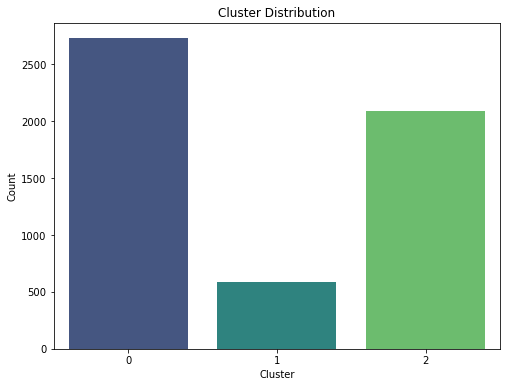

In [34]:
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster', data=df, palette='viridis')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


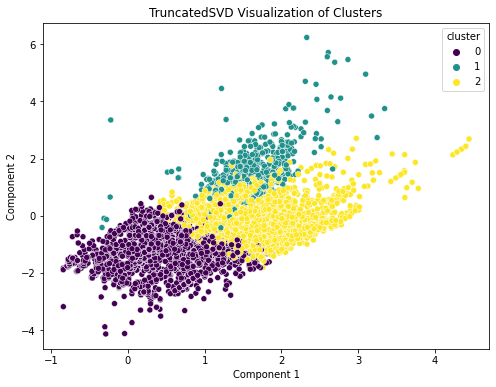

In [35]:
from sklearn.decomposition import TruncatedSVD

# Perform dimensionality reduction using TruncatedSVD
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_processed)

component_names = ['Component {}'.format(i+1) for i in range(X_svd.shape[1])]

# Visualize the clusters in the reduced space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_svd[:, 0], y=X_svd[:, 1], hue=df['cluster'], palette='viridis')
plt.title('TruncatedSVD Visualization of Clusters')
plt.xlabel(component_names[0])
plt.ylabel(component_names[1])
plt.show()

Cluster 0 is largest followed by Cluster 2 and Cluster 1.

Cluster Means:
           rating     price_cv     size_cv  noofratings_cv
cluster                                                   
0        3.861465  2143.880142   17.368275      155.534432
1        4.507890  8165.357873   69.157944     1771.224700
2        4.498424  2058.089232  173.230738      490.169054


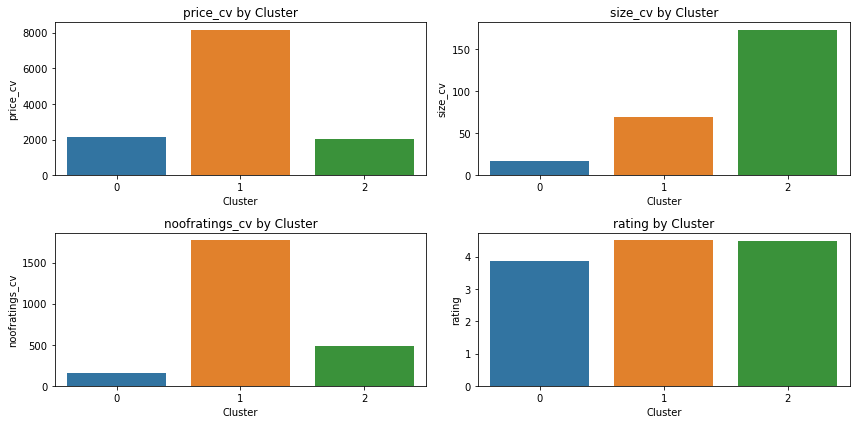

In [37]:
# Create a DataFrame with original data and cluster labels
cluster_df = pd.DataFrame(X, columns=features)
cluster_df['cluster'] = df['cluster']

# Group by cluster and calculate mean values for numeric features
cluster_means = cluster_df.groupby('cluster').mean()

# Display cluster means
print("Cluster Means:")
print(cluster_means)

# Visualize cluster means for numeric features
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numeric_features):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='cluster', y=feature, data=cluster_df, ci=None)
    plt.title('{} by Cluster'.format(feature))
    plt.xlabel('Cluster')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()


Cluster Centers:
      price_cv     size_cv  noofratings_cv    rating  category subcategory  \
0  2143.880142   17.368275      155.534432  3.861465      face    lipstick   
1  8165.357873   69.157944     1771.224700  4.507890  skincare     perfume   
2  2058.089232  173.230738      490.169054  4.498424  skincare       serum   

                                         ingredients    form type     color  \
0  Avocado , Resins, Jellifying Agents, Vitamin E...  liquid  all  No color   
1  Alcohol, Parfum (Fragrance), Aqua (Water), Lin...  liquid  all  No color   
2  Hydrogenated Soybean , Petrolatum, Paraffin, F...  liquid  all  No color   

   product_class brand_class global/local  
0        Regular     Regular       others  
1  Super Premium     Regular       others  
2        Regular     Regular       others  


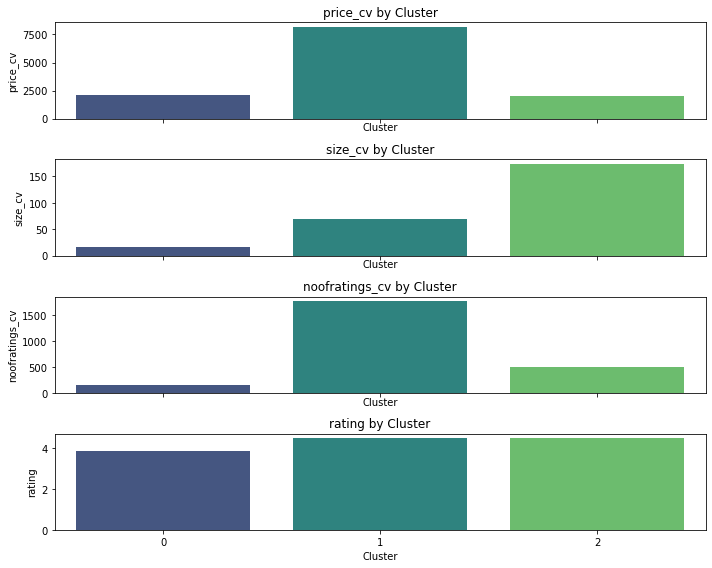

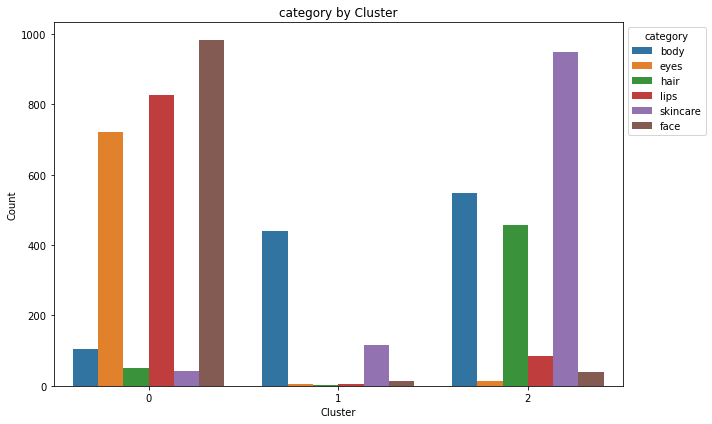

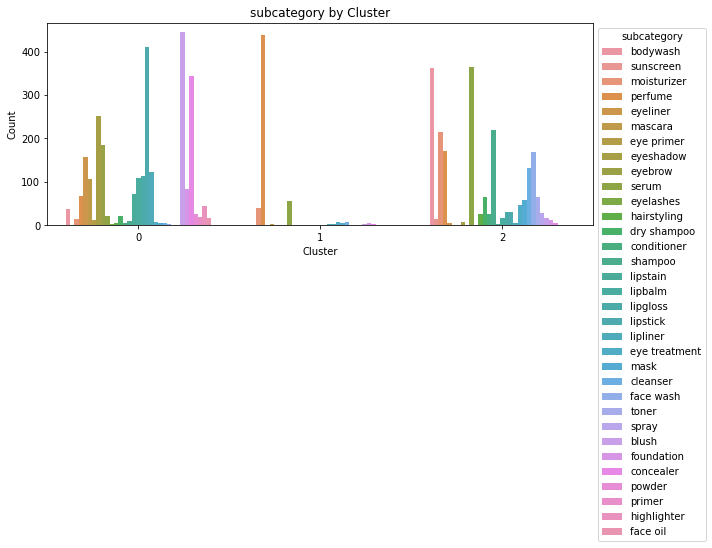

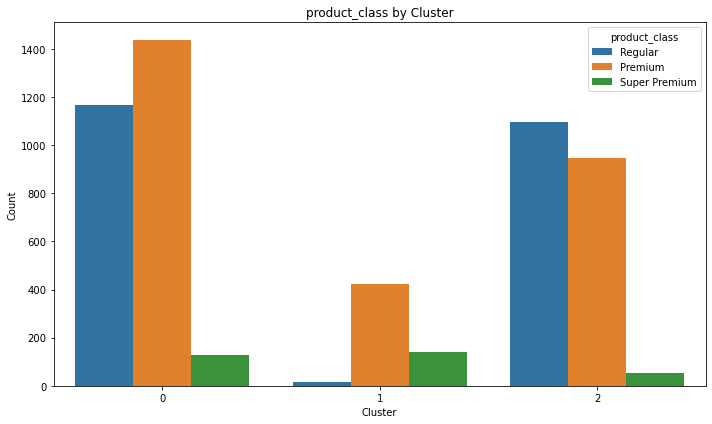

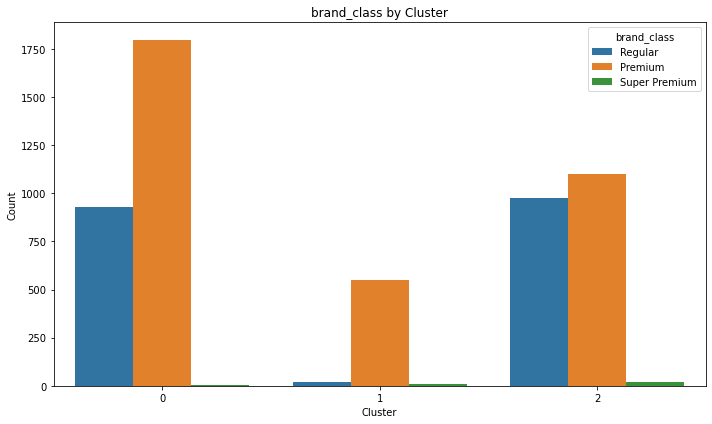

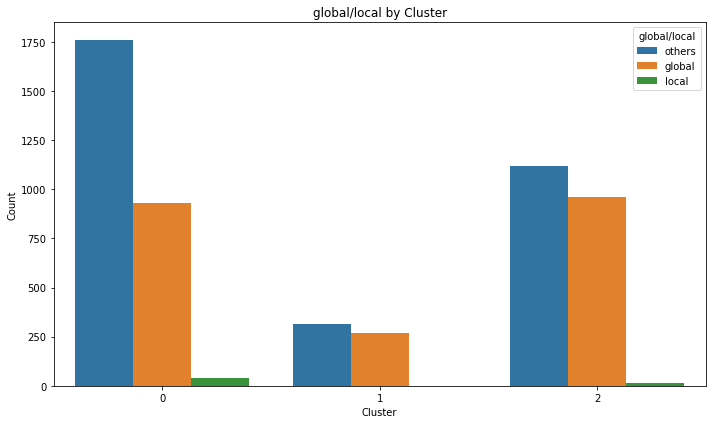

In [47]:
cluster_centers = kmeans.cluster_centers_

# Extract the transformers
scaler = preprocessor.named_transformers_['num']
encoder = preprocessor.named_transformers_['cat']

# Reverse the scaling for numeric features
numeric_centers = scaler.inverse_transform(cluster_centers[:, :len(numeric_features)])

# Get feature names after one-hot encoding
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)
one_hot_encoded_centers = cluster_centers[:, len(numeric_features):]

# Create a DataFrame to store the centers in the original scale
centers_df = pd.DataFrame(numeric_centers, columns=numeric_features)

# Find the most common value for categorical features in each cluster
categorical_centers = []
for i in range(one_hot_encoded_centers.shape[0]):
    cat_values = one_hot_encoded_centers[i, :]
    cat_centers = []
    for j, feature in enumerate(categorical_features):
        # Get the indices for the current feature
        start_idx = sum([len(preprocessor.named_transformers_['cat'].categories_[k]) - 1 for k in range(j)])
        end_idx = start_idx + len(preprocessor.named_transformers_['cat'].categories_[j]) - 1
        
        # Get the most common value for the current feature
        most_common_value_idx = np.argmax(cat_values[start_idx:end_idx])
        most_common_value = preprocessor.named_transformers_['cat'].categories_[j][most_common_value_idx + 1]
        cat_centers.append(most_common_value)
    categorical_centers.append(cat_centers)

categorical_centers_df = pd.DataFrame(categorical_centers, columns=categorical_features)

# Combine numeric and categorical centers
final_centers_df = pd.concat([centers_df, categorical_centers_df], axis=1)
print("Cluster Centers:")
print(final_centers_df)

# Plot the centers to visualize the key features of each cluster
fig, axes = plt.subplots(len(numeric_features), 1, figsize=(10, 8), sharex=True)
for i, feature in enumerate(numeric_features):
    sns.barplot(x=final_centers_df.index, y=final_centers_df[feature], ax=axes[i], palette='viridis')
    axes[i].set_title(f'{feature} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)
plt.tight_layout()
plt.show()

# Plot categorical features for each cluster
for feature in categorical_features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='cluster', hue=feature, data=df)
    plt.title(f'{feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title=feature, bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()


## Key Observations - 

Cluster 0 (50.5%) - avg price is 2143.88, avg size is 17.37, avg number of ratings is 155.53, avg rating is 3.86. Major categories are face > lips > eyes while the major subcategories are blush, lipstick, concealer. The major product class is premium, regular.

Cluster 1 (10.8%) - avg price is 8165.36, avg size is 69.16, avg number of ratings is 1771.22, avg rating is 4.51. Major categories are body > skincare while the major subcategories are perfume. The major product class is premium, super premium.

Cluster 0 (38.7%) - avg price is 2058.09, avg size is 173.23, avg number of ratings is 490.17, avg rating is 4.50. Major categories are skincare > body > hair while the major subcategories are serum, bodywash, shampoo, moisturizer, face wash. The major product class is premium, regular.

### Based on all the results, we can identify 3 main market segments - 
1. Essential Makeup - With the largest no. of distinct products, this segment offers diverse options of essential makeup products for consumers. Despite being priced towards the lower end, these products provide good value for money due to their small size, making them accessible to a broader audience.


2. Luxury Fragrances - The number of products is relatively small, but they command higher prices with high ratings, reflecting their premium positioning. Consumers are willing to invest in these high-quality fragrances, considering them as luxury items or special treats. This is particularly a niche market.


3. Skincare and Bodycare Essentials - Encompassing a comprehensive range of skincare and body care solutions, they are priced towards the lower end. Their larger size reflect their functionality and value for consumers, contributing to their high ratings. They cater to consumers seeking effective and affordable solutions for their skincare and grooming needs.